In [ ]:
%pip install networkx matplotlib

In [2]:
import random

In [3]:
STATES = ["START", "VOLCANO", "BASE", "SITE_A", "SITE_B", "IMMOBILE"]
ACTIONS = ["LEFT", "RIGHT"]

TERMINAL_STATES = {"BASE", "IMMOBILE", "DESTROYED"}

In [15]:
# MARKOV DECISION PROCESS
MDP = {
    "START": {
        "LEFT": [
            {"prob": 0.9, "next_state": "SITE_A", "reward": -1},
            {"prob": 0.1, "next_state": "IMMOBILE", "reward": -3},
        ],
        "RIGHT": [
            {"prob": 0.5, "next_state": "BASE", "reward": 10},
            {"prob": 0.5, "next_state": "DESTROYED", "reward": -10},
        ],
    },

    "SITE_A": {
        "LEFT": [
            {"prob": 1.0, "next_state": "START", "reward": -1},
        ],
        "RIGHT": [
            {"prob": 0.8, "next_state": "SITE_B", "reward": -1},
            {"prob": 0.2, "next_state": "IMMOBILE", "reward": -3},
        ]
    },

    "SITE_B": {
        "LEFT": [
            {"prob": 1.0, "next_state": "SITE_A", "reward": -1},
        ],
        "RIGHT": [
            {"prob": 1.0, "next_state": "BASE", "reward": 10},
        ]
    },

    # Terminal states (no actions)
    "BASE": {},
    "IMMOBILE": {},
    "DESTROYED": {},
}


In [5]:
TERMINAL_STATES = {s for s, a in MDP.items() if len(a) == 0}
ALL_STATES = list(MDP.keys())


In [6]:
def reset_env():
    state = "START"
    done = False
    return state, done


In [16]:
def step_env(state, action):
    if state in TERMINAL_STATES:
        raise ValueError("Episode has terminated. Call reset_env().")

    if action not in MDP[state]:
        raise ValueError(f"Invalid action '{action}' for state '{state}'")

    outcomes = MDP[state][action]

    r = random.random()
    cumulative = 0.0

    for outcome in outcomes:
        cumulative += outcome["prob"]
        if r <= cumulative:
            next_state = outcome["next_state"]
            reward = outcome["reward"]
            done = next_state in TERMINAL_STATES
            return next_state, reward, done

    # Safety fallback (floating-point issues)
    last = outcomes[-1]
    next_state = last["next_state"]
    reward = last["reward"]
    done = next_state in TERMINAL_STATES
    return next_state, reward, done


In [25]:
def run_episode(policy_fn):
    state, done = reset_env()
    total_reward = 0
    trajectory = []

    while not done:
        action = policy_fn(state)
        next_state, reward, done = step_env(state, action)

        trajectory.append((state, action, reward, next_state))
        total_reward += reward
        state = next_state

    return trajectory, total_reward



In [26]:
def random_policy(state):
    actions = list(MDP[state].keys())
    return random.choice(actions)


In [19]:
def greedy_policy(state):
    if state == "START":
        return "LEFT"
    if state in ["SITE_A", "SITE_B"]:
        return "RIGHT"
    raise ValueError("No action available")


In [46]:
trajectory, total_reward = run_episode(greedy_policy)

for step in trajectory:
    print(step)

print("Total reward:", total_reward)


('START', 'LEFT', -1, 'SITE_A')
('SITE_A', 'RIGHT', -3, 'IMMOBILE')
Total reward: -4


In [53]:
def evaluate_policy(policy_fn, episodes=10000):
    rewards = []
    for _ in range(episodes):
        _, total = run_episode(policy_fn)
        rewards.append(total)
    return sum(rewards) / len(rewards)


In [52]:
print("Greedy policy avg reward:", evaluate_policy(greedy_policy))
print("Random policy avg reward:", evaluate_policy(random_policy))


Greedy policy avg reward: 4.4
Random policy avg reward: 1.8


In [76]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_mdp_graph(MDP):
    G = nx.DiGraph()

    for state, actions in MDP.items():
        if not actions:  # terminal state
            G.add_node(state)
            continue

        for action, outcomes in actions.items():
            for o in outcomes:
                label = f"{action}\nP={o['prob']}, R={o['reward']}"
                G.add_edge(state, o["next_state"], label=label)

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(14, 10))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=2800,
        node_color="lightgray",
        font_size=10,
        arrows=True
    )

    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Mars Rover MDP")
    plt.show()


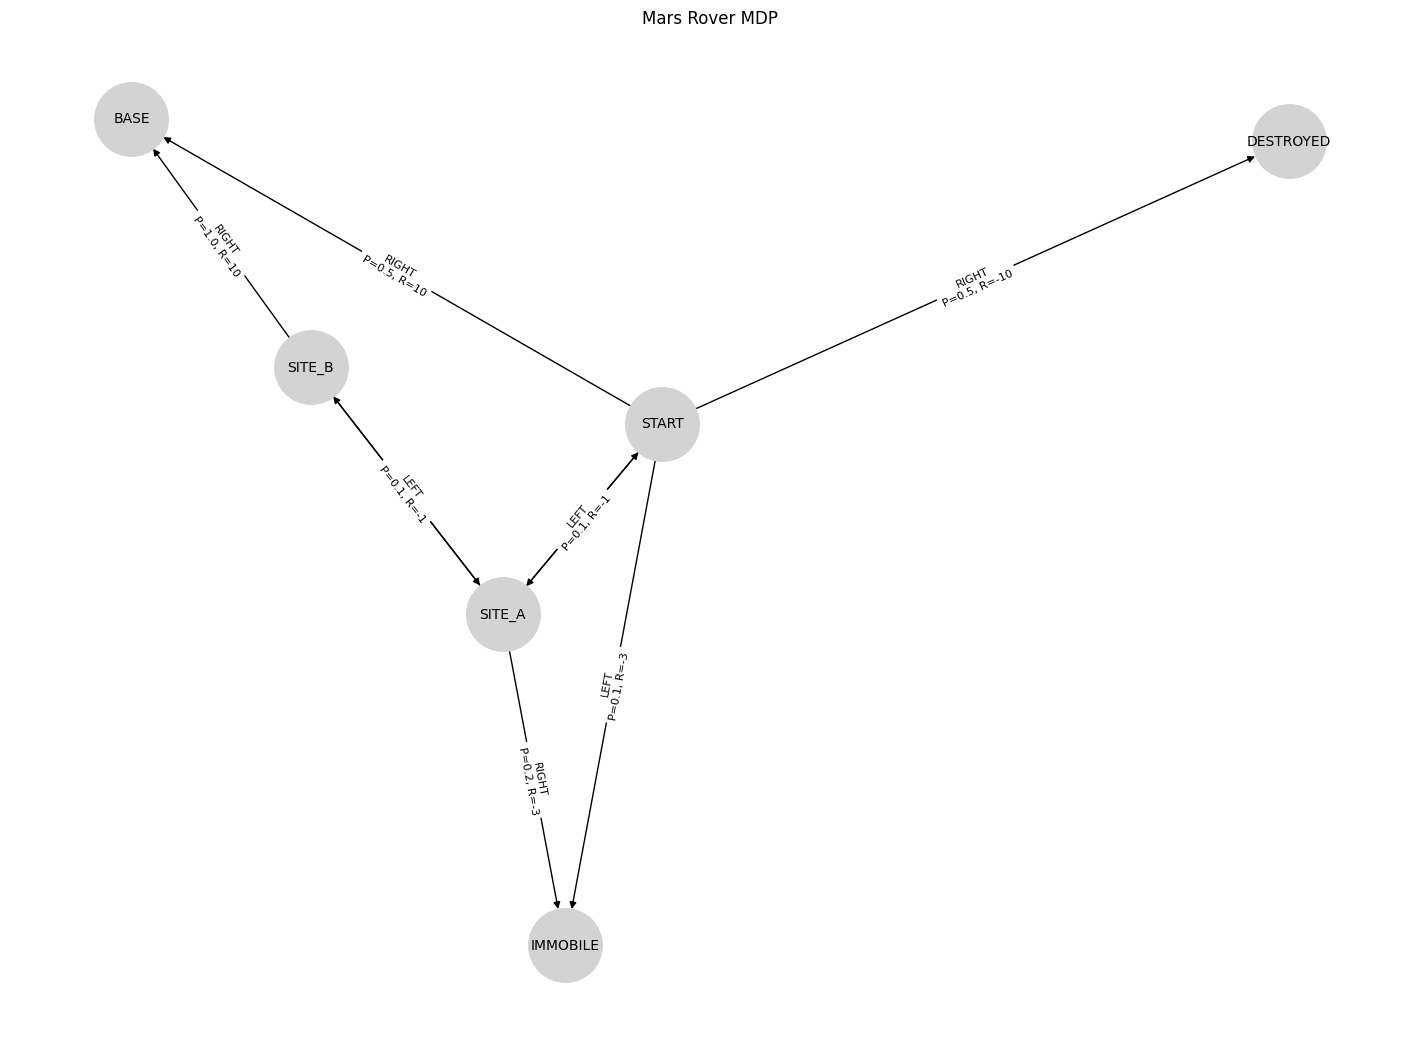

In [66]:
plot_mdp_graph(MDP)